In [1]:
import h5py

# Load the HDF5 file
with h5py.File('cell_data.h5', 'r') as f:
    print(list(f.keys()))  # Show top-level groups, i.e., B01, B02, etc.

['B01', 'B02', 'B05', 'B07', 'B20']


**(a) Plot the number of images per brain.**

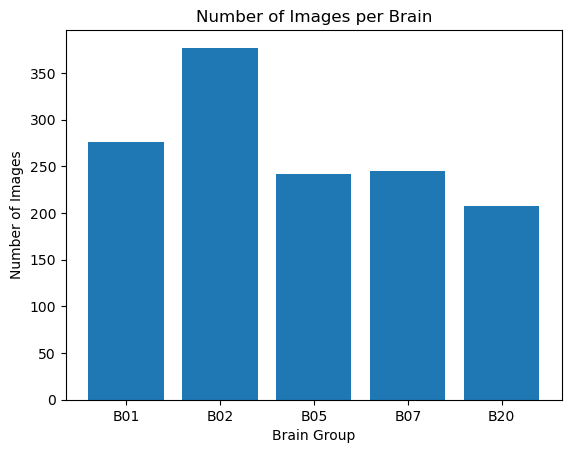

{'B01': 276, 'B02': 377, 'B05': 242, 'B07': 245, 'B20': 208}


In [2]:
import matplotlib.pyplot as plt

# Count images per brain
image_counts = {}
with h5py.File('cell_data.h5', 'r') as f:
    for brain in f.keys():
        image_counts[brain] = len(f[brain])

# Plot
plt.bar(image_counts.keys(), image_counts.values())
plt.xlabel('Brain Group')
plt.ylabel('Number of Images')
plt.title('Number of Images per Brain')
plt.show()

print(image_counts)

**(b) Plot the distribution of image sizes in an interpretable way**

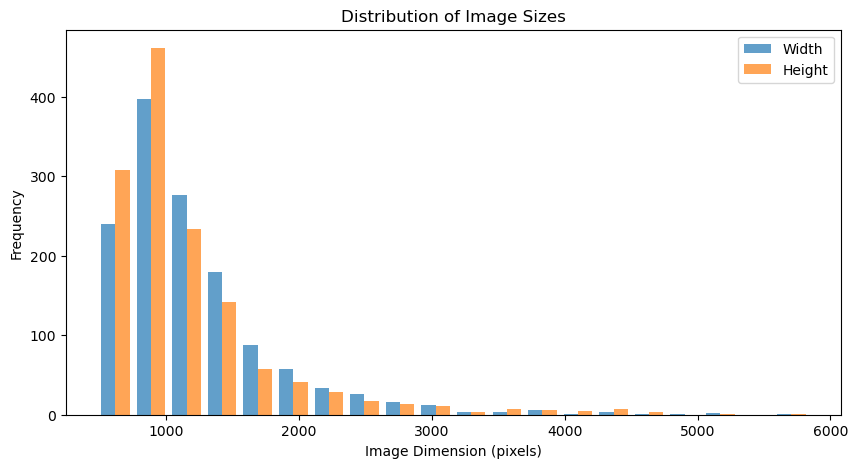

Widths: min: 484 max: 5594 mean: 1222.2589020771513
Heights: min: 513 max: 5840 mean: 1161.5548961424333


In [3]:
import numpy as np

image_sizes = []
with h5py.File('cell_data.h5', 'r') as f:
    for brain in f.keys():
        for img in f[brain]:
            data = f[brain][img]
            image_sizes.append(data.shape)

# Assuming the images are 2D, you could extract width and height separately
widths = [size[1] for size in image_sizes]
heights = [size[0] for size in image_sizes]

# Plot
plt.figure(figsize=(10, 5))
plt.hist([widths, heights], label=['Width', 'Height'], bins=20, alpha=0.7)
plt.legend(loc='upper right')
plt.xlabel('Image Dimension (pixels)')
plt.ylabel('Frequency')
plt.title('Distribution of Image Sizes')
plt.show()

print('Widths:', 'min:', np.min(widths), 'max:', np.max(widths), 'mean:', np.mean(widths))
print('Heights:', 'min:', np.min(heights), 'max:', np.max(heights), 'mean:', np.mean(heights))

**(c) Checkout the largest and smallest images per brain and visualize them.**

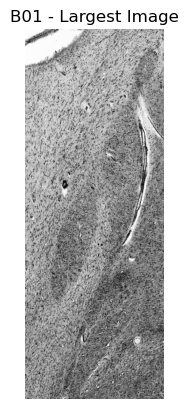

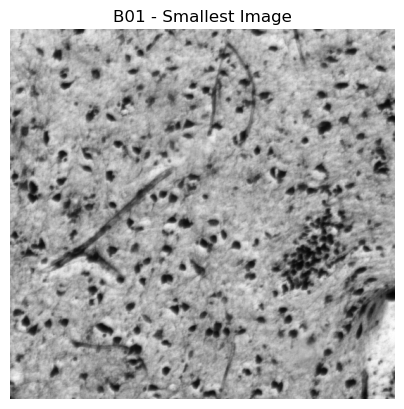

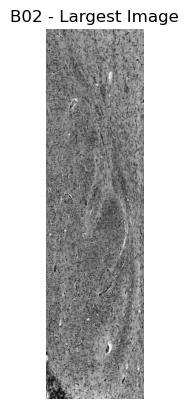

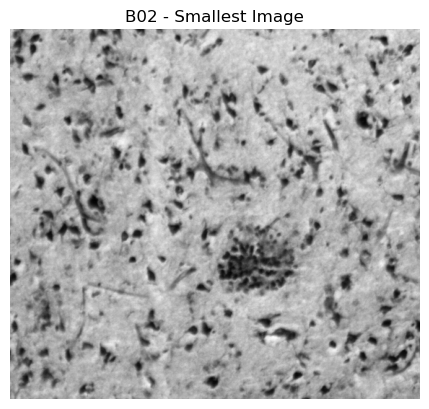

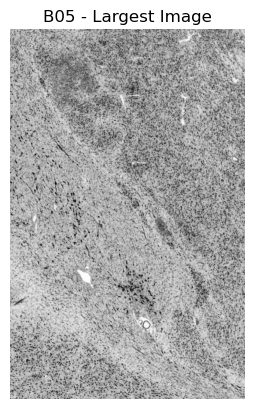

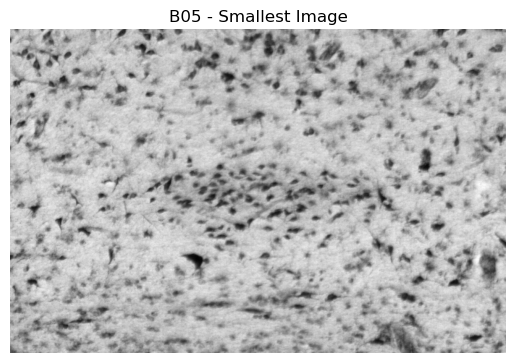

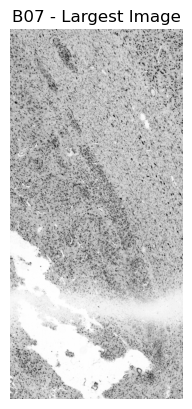

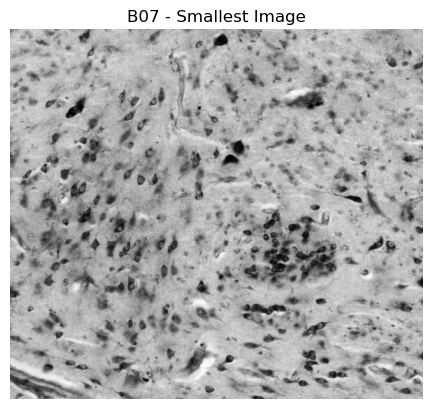

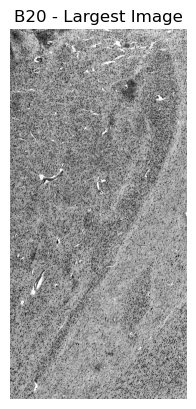

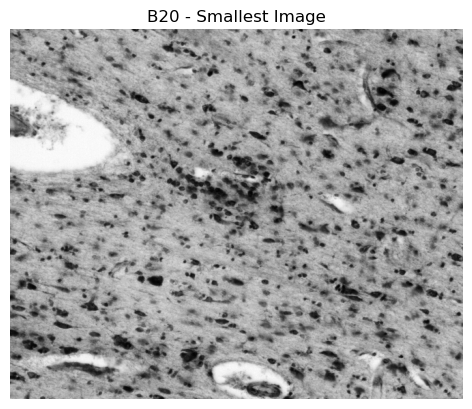

In [4]:
import matplotlib.pyplot as plt

def plot_image(data, title):
    plt.imshow(data, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

with h5py.File('cell_data.h5', 'r') as f:
    for brain in f.keys():
        sizes = {img: f[brain][img].shape for img in f[brain]}
        largest = max(sizes, key=sizes.get)
        smallest = min(sizes, key=sizes.get)

        # Plot the largest and smallest
        plot_image(f[brain][largest][()], f'{brain} - Largest Image')
        plot_image(f[brain][smallest][()], f'{brain} - Smallest Image')

**(d) Based on your data exploration decide for one test brain group and keep the other
groups for training.**

In [5]:
training_brains = ['B01', 'B02', 'B05', 'B07']  # Example selection where B20 is the test set

all_pixels = []
with h5py.File('cell_data.h5', 'r') as f:
    for brain in training_brains:
        for img in f[brain]:
            data = f[brain][img][()]
            all_pixels.append(data.flatten())

# Flatten all pixels into one array for easier calculations
all_pixels = np.concatenate(all_pixels)
global_min = np.min(all_pixels)
global_max = np.max(all_pixels)
global_mean = np.mean(all_pixels)
global_std = np.std(all_pixels)

# Store results
stats = {
    'min': global_min,
    'max': global_max,
    'mean': global_mean,
    'std': global_std
}
print(stats)

{'min': 0, 'max': 255, 'mean': 152.55165779329369, 'std': 48.7406656161532}


**(e) Determine and store the global maximum, minimum, mean and standard deviation
for the image pixel values of the training data**

Loading cached statistics for test set B20...


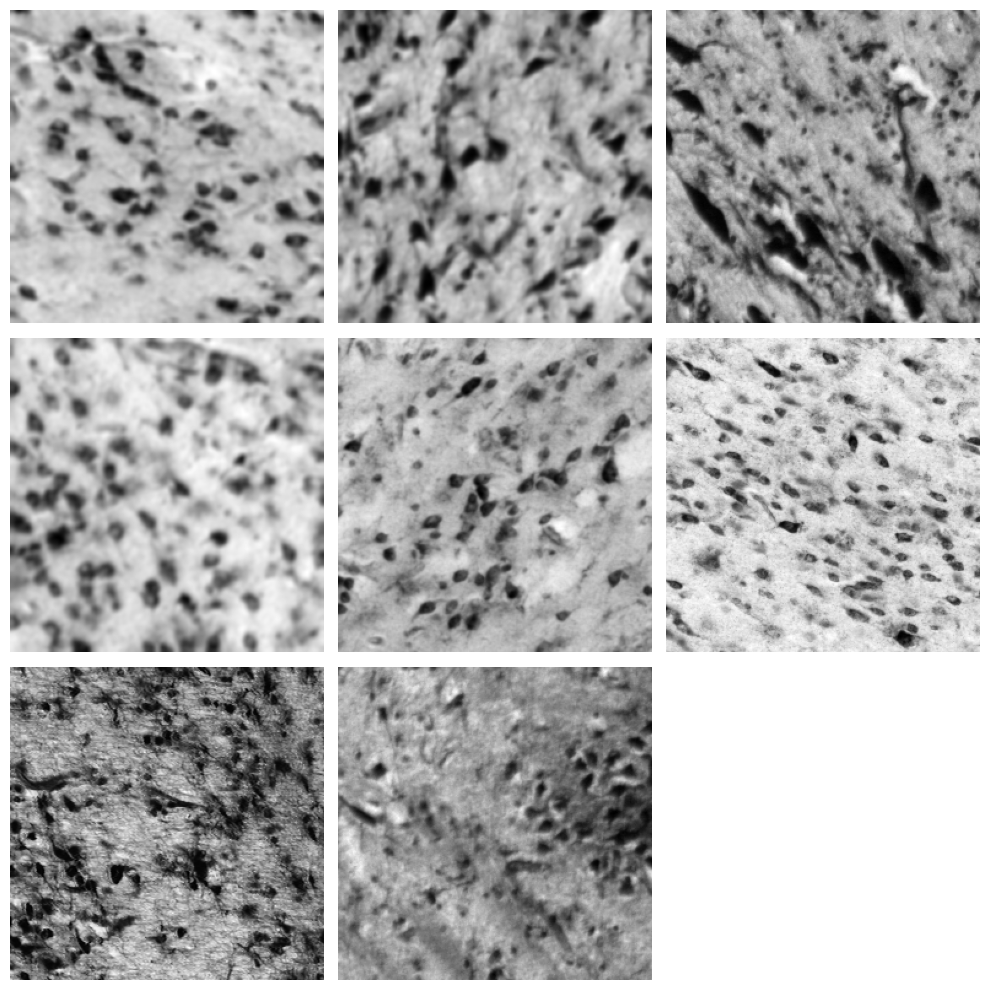

In [6]:
from src.utils import visualize_batch, calculate_statistics
from src.data_processing import BrainTileDataset, DensityBasedSampler
import torch
from torch.utils.data import DataLoader

data_path = 'cell_data.h5'
test_set = 'B20'

# Calculate global statistics
global_stats = calculate_statistics(data_path, test_set)

tile_size = 256
batch_size = 8
samples_per_epoch = 1024

train_dataset = BrainTileDataset(data_path, global_stats, test_set=test_set, tile_size=tile_size)
train_sampler = DensityBasedSampler(train_dataset, samples_per_epoch)

# Create training data loader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,
    collate_fn=lambda x: torch.stack([item for item in x])
)

# Visualize first batch of training data
for batch in train_dataloader:
    visualize_batch(batch, global_stats)
    break